In [42]:
'''A identificacao dos motifs e determinada, geralmente, 
por uma funcao de distancia (D) e a fixacao de um limiar de aceitacao (r). 
Assim, se r e um limiar de aceitacao real positivo, 
uma serie temporal com uma subsequencia C1 iniciada na posicao p, e outra subsequencia C2 na posição q, 
seja D a distancia entre dois objetos, D(c1,c2)r , entao assume-se que a subsequencia C1 e similar a subsequencia C2.
    Como os dados de diferentes series foram comparados, todas as s e subsequencias separadas sao normalizadas 
para minimizar os problemas oriundos do uso de unidades e dispersoes distintas entre as variaveis. 
Para sabermos quais subsequencias se repetem em uma serie temporal, foi utilizada a tecnica Matrix Profile (MP). 
Nessa técnica, seja T uma serie temporal, a matrix profile se trata de uma comparação da curva de luz normalizada com 
ela mesma por distancia euclidiana, onde a i-esima posicao marca a distancia da subsequencia em T, 
na i-esima posicao, ao seu vizinho mais próximo presente em T onde quer que este esteja na curva, 
possibilitando um gráfico de posicao por menor distancia euclidiana em toda a seria excluindo combinacoes triviais.
No agrupamento das subsequências selecionadas, para que cada grupo seja a representação de um motif, 
buscamos minimizar as distancias intra-grupos e maximizar a distancia extra-grupos. 
Para sabermos a qualidade do agrupamento, utilizamos a medida de qualidade para clusters chamada Silhouette Coefficient, 
que e calculado da seguinte maneira, a media das distancias intra-grupo (a) 
e a distancia entre a amostra e o grupo mais proximo que ela nao pertence (b) para cada amostra, 
o Silhouette Coefficient e dado por (b - a)/max(a,b) sendo 1 o melhor valor possivel para a qualidade e -1 o pior resultado.
'''
'''to indentify motifs, its used the Matrix Profile (MP), where its selected the subsequences corresponding to the minimals 
located outside the interval between the mean less 2*standard deviation of the curve MP, from each time series using self join.
Them all the selected subsequences are compared with each other by euclidean or pearson distance, to then be grouped with 
the subsequences that the distance metric is inside the acceptance threshold adopted'''








NumberOfCurves= 10
import os
os.chdir('C:\\Users\\Usuario\\Desktop\\exopla') #Path database
import pandas as pd
import numpy as np
cv = pd.read_csv('exoTrain.csv')
data = []
for i in range(NumberOfCurves):
    Time = np.asarray(cv.loc[i,:])
    data.append(Time)
    
    
    
#Welcome to the controll station, here you will be able to manipulate the data, values and bounds.
database = data        #list of arrays, each array being a time series
NumberOfCurves= 10   #int, curves that will be considered, from the first to NumberOfCurves
WindowStart= 200     #int, First Size of the sliding window to the search of subseries that culd be a patern
MaxWindowSize= 400 #int, Max size the window will reach
WindowGrowth= 100    #int, How much the size of the window will grow each time the serch for paterns ends
metric2 = 'euclidean'   #'euclidean' or 'pearson', the metric used to build the matrix of similarity between the selected subsequences, inside distance profile

#Clustering
RadiusTimes10Start = 1       #acceptance threshold *10, value of distance between the most similar subsequence until the end of the acptance interval to start the clustering
RadiusTimes10MaxPlus1 = 81   #acceptance threshold *10 + 1, end value
RadiusTimes10Growth = 1      #acceptance threshold *10, growth rhythm





#let us begin by importing tools

import matplotlib.pyplot as plt
import numpy as np
from biosppy.signals import tools

    

#1 criando lista de possiveis motifs para m janelas curva por curva
ListMotifs=[]
#localMotifs=[]
#MaxWindowSize= 50          ?????????
#WindowSize= 10

for a in range(NumberOfCurves):
    TimeSeries= database[a]
    signalsSource= TimeSeries
    sinal2=[]
    sinal=[]
    sinal1=[]
    
    H= tools.normalize(signal=signalsSource, ddof=1) #Normalize to standard deviation 1
    sinal2.append(H[0])
    sinal1= sinal2[0][1:]
    sinal= signalsSource
    
    #'''self join mp'''
    info=[]
    localm1=[]
    for m in range(WindowStart,MaxWindowSize,WindowGrowth):
            ind , ProfileMatrix =tools.signal_self_join(signal=sinal1, size= m, index=None, limit=None) #matrix profile  from normalize dd1


            #'''minimos da matrix profile'''
            desv= ProfileMatrix.std()
            med= ProfileMatrix.mean()
            ln = len(ProfileMatrix)
            M= []
            for c in range(ln -1):
                if (ProfileMatrix[c - 1]>ProfileMatrix[c]<ProfileMatrix[c + 1]):    #minimo local
                    if( ProfileMatrix[c]< (med - (2*desv))):      #se esta na faixa dos 4,56% valores mais afastados da media / if it is in the 4,56% values with the biggest distance from the mean
                        if(c%3197+m<len(signalsSource)):       #se do minimo ao fim da janela, o motif esta dentro da curva / if minimal to the end of the window, the motif is inside the curve
                            M.append(c)


            #'''lista de motifs normalizados'''
            ListMotifsNotNormalized= []
            for e in range(len(M)):
                f= sinal[M[e]:M[e]+m]
                ListMotifsNotNormalized.append(f)
            for z in range(len(ListMotifsNotNormalized)):                       #Normalized motifs list from all curves
                R= tools.normalize(signal=ListMotifsNotNormalized[z], ddof=1)
                ListMotifs.append(R[0])

#2 tabela de distancia entre motifs
DistMotifs= []
DMp=[]
LM = ListMotifs
for i in range(len(LM)):
    for j in range(i+1,len(LM)):
        if(len(LM[i])<=len(LM[j])/2):                                                      #here we compare different size curves by sliding the shorter one into the bigest and saving the euclidean distance values
            eucli = tools.distance_profile(query=LM[i], signal=LM[j], metric=metric2)
            eucli=eucli[0]
        elif(len(LM[i])/2>=len(LM[j])):
            eucli = tools.distance_profile(query=LM[j], signal=LM[i], metric=metric2)
            eucli=eucli[0]
        else:                                                                              #the tool used can only calculate the euclidean distance if the bigger curve has at least duble the size, so when that is not the case, the biggest one is concatenated with itself and only the values that are from the originals ones are considered
            
            if(len(LM[i])>=len(LM[j])):
                o=[]
                o= np.concatenate((LM[i], LM[i]), axis=0)
                eucli = tools.distance_profile(query=LM[j], signal=o, metric=metric2)
                eucli= eucli[0]
                a=[]
                for b in range(len(LM[i])-len(LM[j])+1):
                    a.append(eucli[b])
                eucli= a
            elif(len(LM[i])<len(LM[j])):
                o=[]
                o= np.concatenate((LM[j], LM[j]), axis=0)
                eucli = tools.distance_profile(query=LM[i], signal=o, metric=metric2)
                eucli= eucli[0]
                a=[]
                for b in range(len(LM[j])-len(LM[i])+1):
                    a.append(eucli[b])
                eucli= a
             
        DMp.append(np.min(eucli))
    DistMotifs.append(DMp)                                                                #DistMotifs has the minimal distance value from the comparison between each curve in ListMotifs 
    DMp= []
    
#salvando LM e distmotifs
import pickle
l=DistMotifs
with open("distmotifs.txt", 'wb') as fp:
    pickle.dump(l, fp)
with open("LM.txt", 'wb') as fp:
    pickle.dump(LM, fp)


#3 Agrupamento - variando o raio para o agrupamento, guardando raio e medida de qualidade
ra=[]
medidaqualidade= []
informacao=[]
for rai in range(RadiusTimes10Start, RadiusTimes10MaxPlus1, RadiusTimes10Growth):
    with open('distmotifs.txt', 'rb') as fp:
        D= pickle.load(fp)                                  #D = DistMotifs
    raio= rai/10
    # agrupando motifs
    g=[]
    for a in range(len(D)):
        gg=[]
        c= a - 1
        h=0
        for u in range(len(g)):
            if c not in (g[u]):
                h=h+1
        if(h==len(g)):
            if D[a] != []:
                gg.append(a-1)
                for p in range(int(MaxWindowSize/WindowGrowth)-2):       #armazena todos os possiveis casos em que a curva se repitiu em tamanhos diferentes
                    b= np.argmin(D[a])
                    c= b + a
                    h=0
                    for u in range(len(g)):
                        if c not in (g[u]):
                            h= h + 1
                    if(h==len(g)):
                        gg.append(c)
                        D[a][b]= 50
                for d in range(len(D[a])):
                    if(D[a][d]<=(np.min(D[a])+ raio)):                   #armazena todas as curvas dentro da distancia da curva mais semelhante (fora os casos acima) mais o raio
                        c= a+d
                        h=0
                        for u in range(len(g)):
                            if c not in (g[u]):
                                h= h + 1
                        if(h==len(g)):
                            gg.append(c)
                g.append(gg)                                            #g contains all the separations of groups, being a list of arrays where each array is a group and each element is the index -1 of a curve in the ListMotif

    #salva o agrupamento
    l=g
    with open(str(raio)+"groups.txt", 'wb') as fp:
        pickle.dump(l, fp)

    #4 Qualidade do agrupamento
    with open('distmotifs.txt', 'rb') as fp:
            DistMotifs= pickle.load(fp)
    
    #comparação de distancias intra grupo
    ç=0
    o=[]
    gg= []
    for f in range(len(g)):                                                         #deleta todos os grupos com menos de 2 integrantes
        if(len(g[f])<2):
            gg.append(f)
    for f in range(len (gg) - 1, -1, -1):
        del(g[gg[f]])

    for u in range(len(g)):
        i=[]
        for v in range(len(g[u])):
            j=[]                                                                     #j contains the distance between each member of the group
            for l in range(len(g[u])):
                if(g[u][v]!=g[u][l]):
                    if(g[u][v]<g[u][l]):
                        j.append(DistMotifs[g[u][v] + 1][g[u][l]- g[u][v] - 1])
                    else:
                        j.append(DistMotifs[g[u][l] + 1][g[u][v]- g[u][l] - 1])
            a=0
            for n in range(len(j)):
                a= a + j[n]
            a= a/len(j)                                                              
            i.append(a)
        o.append(i)                                                                 #o contains the means of the distances of each member compared to all the others members of the group
    medg=[]
    centroides=[]
    for r in range(len(o)):
        centroides.append(np.argmin(o[r]))                                          #centroides contains the index of the member most similar to all others in the group 
        medg.append(np.min(o[r]))
    me=0
    for r in range(len(medg)):
        me= me + medg[r]
    valorintra= me/len(o)                                                           #valorintra contains the mean of the minimal mean distante inside each group

    #comparação de distâncias extra grupos
    centros=[]
    i=[]
    for l in range(len(centroides)):                                                #centro contains the index of the representative of each group
        centros.append(g[l][centroides[l]])
    a=0
    for v in range(len(centros)):
        j=[]
        for l in range(len(centros)):
            if(centros[v]!=centros[l]):
                if(centros[v]<centros[l]):
                    j.append(DistMotifs[centros[v] + 1][centros[l]- centros[v] - 1])
                else:
                    j.append(DistMotifs[centros[l] + 1][centros[v]- centros[l] - 1])
    
        a= min(j)                                                                 #a contains the distance to the representative of the group with the most similar representative of other group
        i.append(a)
    aa=0
    for n in range(len(i)):
        aa= aa + i[n]
    valorextra= aa/len(i)                                                         #valorextra contains the mean of the minimal distances of the closest representatives

    #medida de qualidade
    #print('ve',valorextra,'vi',valorintra)
    mq= (valorextra - valorintra)/max(valorintra, valorextra)
    ra.append(raio)
    medidaqualidade.append(mq)                                                   #medida de qualidade contains the qualite measure adopted of the clustering
    #print('medidade de qualidade para ', raio, ' : ', mq)
    
    #salva os representantes
    Representatives=[]
    for nrepresentatives in range(len(centros)):
        Representatives.append(LM[centros[nrepresentatives] + 1])
    with open(str(raio) + "representants"+".txt", 'wb') as fp:
        pickle.dump(Representatives, fp)
        

informacao.append(ra)
informacao.append(medidaqualidade)
with open("informacao.txt", 'wb') as fp:                                         #informacao contains each radius size and the compatible quality measure of the clustering
    pickle.dump(informacao, fp)



In [43]:
print(informacao)

[[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0, 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5.0, 5.1, 5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6.0, 6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 6.9, 7.0, 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8, 7.9, 8.0], [0.7447543925577248, 0.7123478477066627, 0.6966642426151946, 0.7175122930824214, 0.696289230849772, 0.7126513683797946, 0.6674941459655729, 0.6681595567831318, 0.6921177168170178, 0.6886134947395466, 0.6808504468951859, 0.6766701600165012, 0.5788180021012849, 0.5642262967153864, 0.59186769660454, 0.5248353151745074, 0.5173937389519926, 0.47678758866818943, 0.5120442703751231, 0.4978277671397367, 0.5075968343097398, 0.4573830628805955, 0.4573370216185965, 0.4448593957569428, 0.4507316125044968, 0.4503657017134939, 0.44740613066337026, 0.4515822291725189, 0.4649808253889137, 0.524939886732466

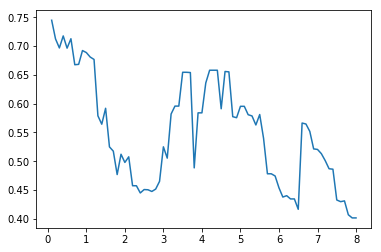

In [44]:
plt.plot(informacao[0], informacao[1])
plt.show()

In [1]:
50//40

1